# Plot Covariance Matrices for Real and Generated Data

**Set Time ID** 

In [1]:
load_time_id: str = "20250118-5882"

In [2]:
from argparse import ArgumentParser
from energydiff.utils import configuration
def notebook_parser(load_time_id: str) -> configuration.ExperimentConfig:
    r"""Fast way to parse arguments for inference
    
    Required:
        - load_time_id: str
        - [dep] load_milestone: int
        
    **All unspecified arguments will be the same as the training arguments.**
    
    Preferrably to be specified:
        - val_batch_size: int
        - num_sample: int
        - num_sampling_step: int
        - dpm_solver_sample: bool
    
    """
    parser = ArgumentParser(
        prog='HeatoDiff Inference',
        description='load and inference diffusion. '
    )
    parser.add_argument('--load_time_id', type=str, default=load_time_id, help='time id to load')
    # parser.add_argument('--load_milestone', required=True, type=int, help='milestone to load')
    parser.add_argument('--val_batch_size', default=None, type=int, help='batch size for validation/testing')
    parser.add_argument('--num_sample', default=None, type=int, help='number of samples to generate every n steps')
    parser.add_argument('--num_sampling_step', default=None, type=int, help='number of sampling steps')
    parser.add_argument('--dpm_solver_sample', default=None, help='whether to use dpm solver for sampling')
    
    args, _ = parser.parse_known_args()
    
    # load training config
    exp_config = configuration.ExperimentConfig.from_yaml(f'results/configs/exp_config_{args.load_time_id}.yaml')
    
    exp_config.model.load_time_id = args.load_time_id
    # exp_config.model.load_milestone = args.load_milestone
    if args.val_batch_size is not None:
        exp_config.sample.val_batch_size = args.val_batch_size
    if args.num_sample is not None:
        exp_config.sample.num_sample = args.num_sample
    if args.num_sampling_step is not None:
        exp_config.sample.num_sampling_step = args.num_sampling_step
    if args.dpm_solver_sample is not None:
        exp_config.sample.dpm_solver_sample = args.dpm_solver_sample
    
    return exp_config

In [3]:
import os
import numpy as np
import torch
import wandb
from einops import rearrange
from energydiff.utils.initializer import create_dataset, get_task_profile_condition
from energydiff.utils.plot import plot_acf_comparison
from energydiff.utils.eval import estimate_autocorrelation

os.chdir("../../../")
print(os.getcwd())

def load_all_generated_data(api, config) -> dict:
    # Get all artifacts in the project
    run = api.run(f"{config.wandb_project}/{config.wandb_id}")
    artifacts = [_ar for _ar in run.logged_artifacts() if _ar.type == 'generated_data']
    name_all_models = set([artifact.name.split('_generated_data-')[0] for artifact in artifacts])

    generated_datasets = {}
    # Look for artifacts with names ending in _generated_data
    for model_name in name_all_models:
        artifact = api.artifact(
            f"{config.wandb_project}/{model_name}_generated_data-{config.wandb_id}:latest",
        )
        data_dir = artifact.download()
        data = torch.load(data_dir+"/generated_data.pt", map_location='cpu')
        
        generated_datasets[model_name] = data
        
        print(f"Loaded generated data from {model_name}")
    
    return generated_datasets

def get_metric_results(source, target, metrics) -> dict:
    source = rearrange(source, "b c l -> b (l c)")
    # eval functions
    target = rearrange(target, 'b c l -> b (l c)')
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    try:
        source = source.to(device)
        target = target.to(device)
        metrics = metrics.to(device)
        results = metrics(source, target)
    except Exception as e:
        print(f"Error: {e}")
        device = torch.device('cpu')
        source = source.to(device)
        target = target.to(device)
        metrics = metrics.to(device)
        results = metrics(source, target)
        
    return results

/Users/nanlin/miniforge3/envs/energydiff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/nanlin/Documents/Projecten/HeatoDiff


In [4]:
config = notebook_parser(load_time_id)
    
# Get original run
api = wandb.Api()
original_run = wandb.init(project=config.wandb_project, id=config.wandb_id, resume='must')

# Get real data
dataset_collection = create_dataset(config.data)
all_profile, _ = get_task_profile_condition(
    dataset_collection,
    season=config.data.train_season,
    conditioning=config.model.conditioning
)
target = torch.cat([all_profile['val'], all_profile['test']], dim=0)

# Get artifacts
generated_all = load_all_generated_data(api, config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nansense97 (nan-team). Use `wandb login --relogin` to force relogin


Processed data loaded.
All processed data loaded.
Dataset ready.
True


wandb:   1 of 1 files downloaded.  
/var/folders/1l/4hsqmyts089_gc67gmnw8__80000gn/T/ipykernel_88076/3230866671.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Loaded generated data from vae_calibrated


wandb:   1 of 1 files downloaded.  


Loaded generated data from ddpm


wandb:   1 of 1 files downloaded.  


Loaded generated data from gmm


wandb:   1 of 1 files downloaded.  


Loaded generated data from vae


wandb:   1 of 1 files downloaded.  


Loaded generated data from ddpm_calibrated


wandb:   1 of 1 files downloaded.  


Loaded generated data from gan


wandb:   1 of 1 files downloaded.  


Loaded generated data from gan_calibrated


In [5]:
# Process data
if config.data.vectorize:
    target = dataset_collection.inverse_vectorize_fn(target, style=config.data.style_vectorize)
    target = rearrange(target, 'b 1 l -> b l')
    
# Adjust shape of generated
for k, v in generated_all.items():
    generated_all[k] = rearrange(v, 'b 1 l -> b l')
    
# To numpy
target = target.cpu().numpy()
generated_all = {k: v.cpu().numpy() for k, v in generated_all.items()}

# Get autocorrelation
# cov_target = estimate_autocorrelation(target) # [L, L]
cov_target = np.cov(target.T) # [L, L]
dict_cov = {}
for model_name, generated in generated_all.items():
    # _cov_generated = estimate_autocorrelation(generated) # [L, L]
    _cov_generated = np.cov(generated.T) # [L, L]
    dict_cov[model_name] = _cov_generated

In [8]:
# [optional] re-import the plot function
import matplotlib.pyplot as plt
from energydiff.utils.plot import plot_cov_comparison

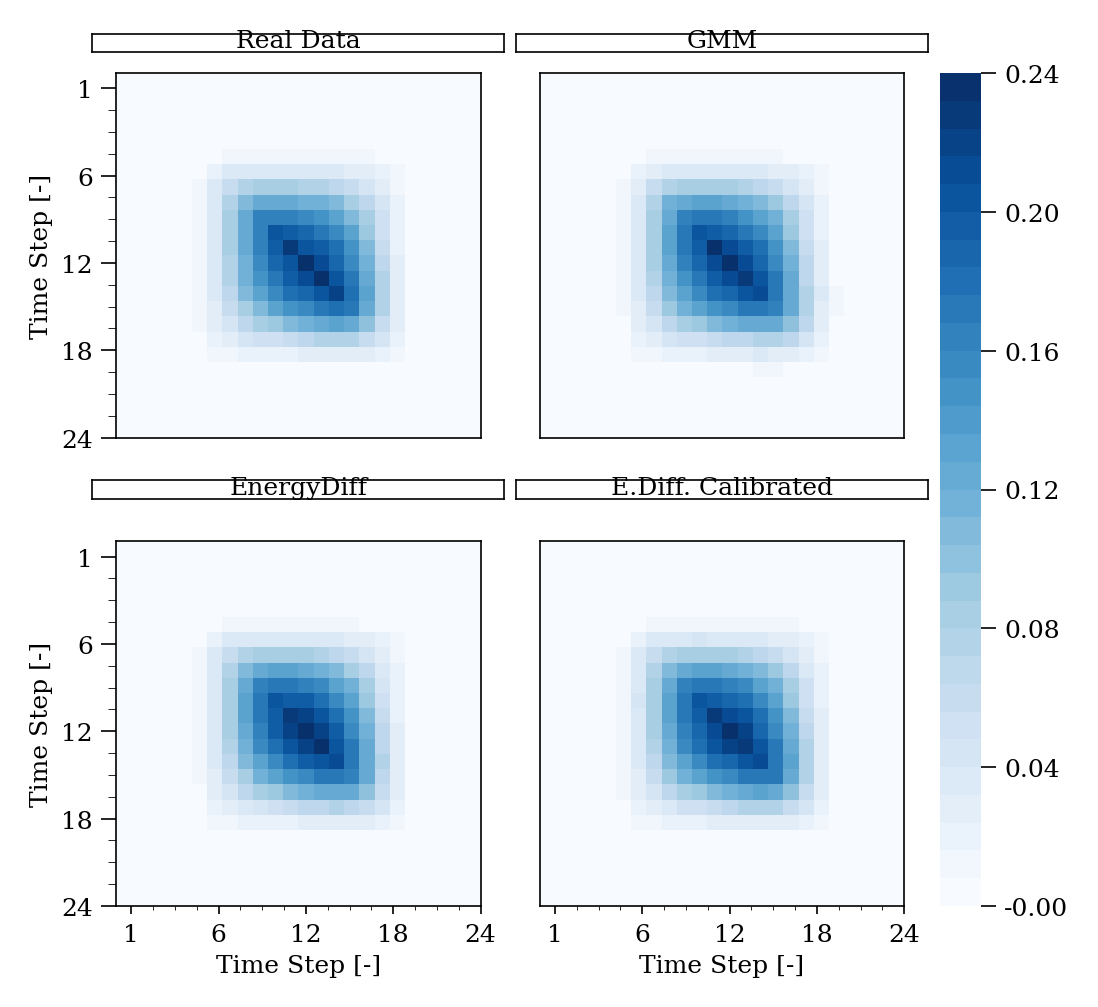

In [9]:
# Plot
fig = plot_cov_comparison(
        dict_cov={
            'Real Data': cov_target,
            'GMM': dict_cov['gmm'],
            'EnergyDiff': dict_cov['ddpm'],
            'E.Diff. Calibrated': dict_cov['ddpm_calibrated'],
        },
        filename=f"cov_{config.time_id}_real_gmm_ddpm_ddpmc.pdf"
    )
plt.show()